<a href="https://colab.research.google.com/github/kubohenrique/churn_prediction/blob/main/DSNP_3_0_Churn_Prediction_para_uma_empresa_de_Telecomunica%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 3.0**
*by [sigmoidal.ai](https://sigmoidal.ai)*  

---

# Churn Prediction

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo, pois se o churn está alto, é porque existe algum problema com o serviço oferecido que está desagradando o cliente, portanto identificar o motivo e melhorar o problema pode diminuir o churn e assim não elevar os prejuízos da empresa.

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

## Importar Bibliotecas

In [51]:
!pip install scikit-plot -q

In [52]:
# importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scikitplot.metrics import plot_confusion_matrix, plot_roc

from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier



## Funções Auxiliares

In [27]:
def converter_str_float(entrada):
    """
    Converte um objeto do tipo string em float.

    # Arguments
        entrada: string, string da coluna TotalCharges.

    # Returns
        Valor convertido em float, caso permita a conversão.
        NaN, caso o valor não seja apropriado.
    """

    try:
        return float(entrada)
    except ValueError:
        return np.nan


def val_model(X, y, clf, quite=False):
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if quite == False:
        print("Recall: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))
    
    return scores.mean()

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [28]:

# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

## Análise Exploratória

Neste ponto irei analisar os dados do dataset, (valores ausentes, valores unicos, tipos de dados, etc).
Dessa maneira fica mais fácil selecionar variáveis para modelar o algoritimo de Machine Learning.

In [29]:
# ver as 5 primeiras entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [30]:
print('Número de Linhas: {}'.format(df.shape[0]))
print('Número de Colunas: {}'.format(df.shape[1]))

Número de Linhas: 7043
Número de Colunas: 21


In [31]:
# Verificando os Valores Nulos no Dataset
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [32]:
# Verificando os tipos de dados:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [33]:
# Verificando os valor únicos:
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

Com estas primeiras Análises deu para verificar que:
* A variável resposta que buscamos é a `Churn`
* A variável `TotalCharges` está como objeto, mas ela é um float.
* A variável `customerID` não tem muita importancia para o modelo.

In [34]:
# criar cópia do dataframe
df1 = df.copy()

# remover coluna costumerID
df1.drop("customerID", axis=1, inplace=True)

# converter as strings de TotalCharges para float
df1["TotalCharges"] = df1["TotalCharges"].apply(converter_str_float)

# verificar entradas ausentes
print("Dados ausentes em 'TotalCharges' (antes):\t{}\n".format(df1["TotalCharges"].isnull().sum()))

# substituir os dados ausentes pelo valor da mediana
TotalChargesMedian = df1.TotalCharges.median()
df1["TotalCharges"].fillna(TotalChargesMedian, inplace=True)

Dados ausentes em 'TotalCharges' (antes):	11



In [35]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.000,0.000,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.000,29.000,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.500,70.350,89.85,118.75
TotalCharges,7043.0,2281.916928,2265.270398,18.80,402.225,1397.475,3786.60,8684.80


Pela descrição estatística, aparentemente não há um outlier aparente, pois os valores máximos não estão tão discrepantes do terceiro quartil, mas irei fazer um boxplot das variáveis: `tenure`, `MonthlyCharges` e `TotalCharges` para verificar melhor isso.

A variável `SeniorCitizen` é aparentemente binária, sendo 0 (não senior) e 1 (senior).

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


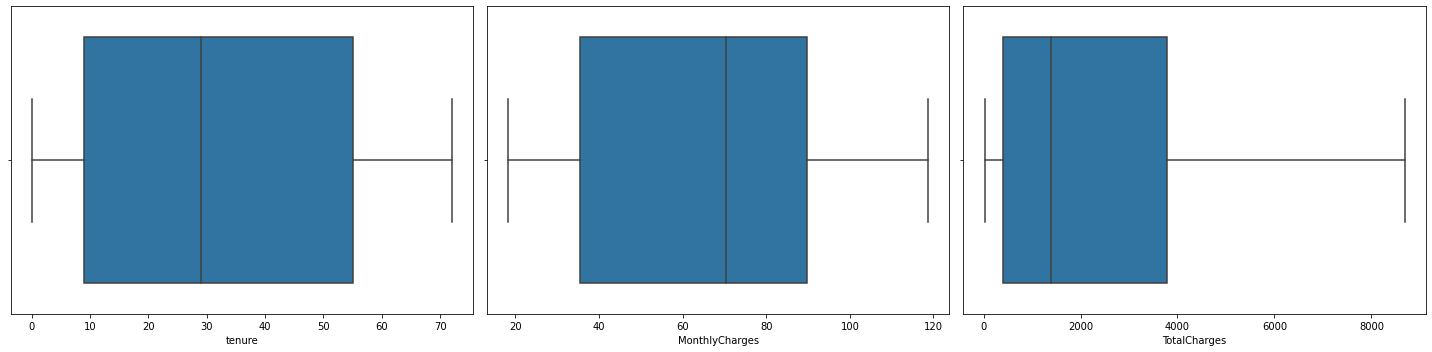

In [36]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

sns.boxplot(df1['tenure'], ax=ax[0])
sns.boxplot(df1['MonthlyCharges'], ax=ax[1])
sns.boxplot(df1['TotalCharges'], ax=ax[2])

plt.tight_layout()

* Pelos gráficos obtidos no boxplots, podemos confirmar que não existe outliers no dataset, pois não existe nenhum plot fora dos limites superiores e inferiores.

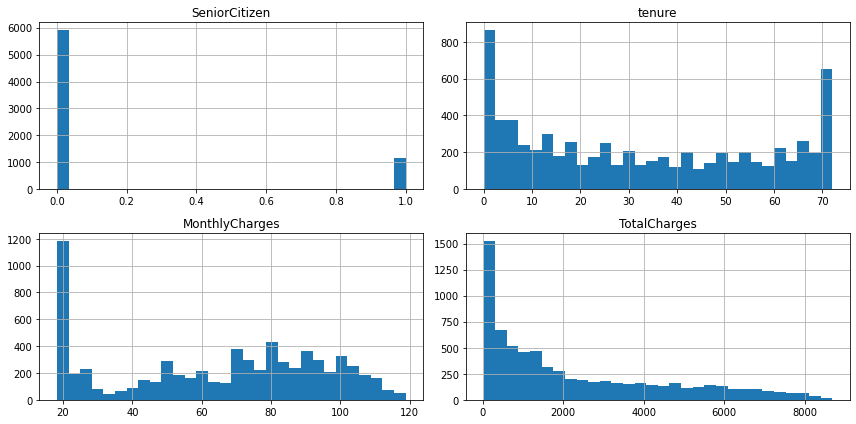

In [37]:
# Ver histogramas das variáveis numéricas:
df1.hist(bins=30, figsize=(12,6));
plt.tight_layout()

Alguns insights:
* A maior parte dos clientes ou estão a pouco tempo na empresa, ou estão a muito tempo sendo cliente dela (observado pelo gráfico de distribuição de `tenure`;
* O valor cobrado por mês é em sua maioria valores pequenos, na faixa de $20.00;
* Achei curioso a colocação da variável `SeniorCitizen` no dataset, a titulo de curiosidade vou comparar o Churn para pessoas seniores:

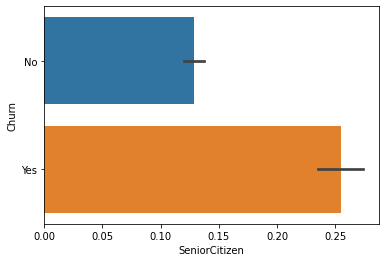

In [38]:
sns.barplot( x='SeniorCitizen', y='Churn', data=df1);

* Aparentemente, pessoas seniores tendem a cancelar os serviços da empresa (resta saber se é por óbito ou apenas mudaram para a concorrente)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


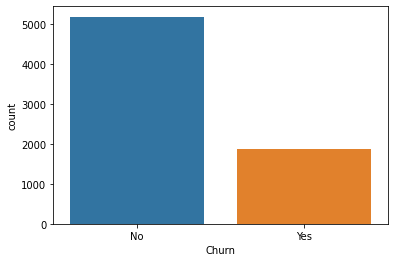

In [39]:
sns.countplot('Churn', data=df1);

* A variável resposta `Churn` está um pouco desbalanceada, e corrigiremos isso mais adiante

## Preparar os dados

Os dados para serem treinados para um modelo de Machine Learning, precisam ser preparados, e agora é o momento de fazermos isso: As features que continham 2 labels únicos, serão processadas usando-se o LabelEncoder. Na sequência, serão separadas as variáveis numéricas das categóricas. As categóricas serão transformadas em variáveis dummy, para permitir a sua utilização em todos os modelos.

In [40]:
# Fazer uma cópia do dataset
df2 = df1.copy()

# Separar o dataset em variáveis numéricas e categóricas
aux = df1.nunique()[df1.nunique() == 2].keys().tolist()
num_var = [col for col in df1.select_dtypes(['int','float']).columns.tolist() if col not in aux]
cat_var = [col for col in df1.columns.tolist() if col not in aux + num_var]

# Label Encoding para as variáveis Binárias
le= LabelEncoder()
for i in aux:
  df2[i] = le.fit_transform(df2[i])

# Encoding para colunas categóricas com múltiplas classes
df2 = pd.get_dummies(df2, columns=cat_var)

# ver as 5 primeiras entradas do novo dataframe
df2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


## Modelo de Machine Learning

Agora que o data set está pre processado, os dados já podem ser utilizados para fazermos a nossa modelagem.

Irei escolher um modelo genérico sem nenhum ajuste nos parametros para criarmos uma *baseline* e podermos fazer uma comparação com outros modelos e parametros ajustados.

Aqui vou dividir o dataset em treino e teste.

A métrica utilizada para fazer a avaliação é o Recall, que verifica qual a porcentagem de dados classificados como positivos comparado com a quantidade real de positivos que existem em nossa amostra, ou seja, buscamos os falsos negativos.

In [41]:
# Separar o valor alvo do resto do dataset:
X = df2.drop('Churn', axis=1)
y = df2['Churn']

# Dividir entre treino e teste:
X_train, X_test, y_train, y_test = train_test_split(X,y)

Agora podemos criar a baseline e verificar seu desempenho:

In [42]:
rf = RandomForestClassifier()
score_baseline = val_model(X_train, y_train,rf)

Recall: 0.48 (+/- 0.03)


O modelo sem nenhuma definição de parametros de mostrou um pouco ineficaz pois acertou apenas 49% dos Churns.

Uma vez que temos um baseline para comparar se os ajustes melhoram ou pioram o desempenho do modelo, irei realizar o balanceamento dos dados e ver como isso irá impactar.

A técnica escolhida foi Under Sampling, após alguns teste de desempenho das outras. Seguindo recomendações de algumas literaturas, os dados serão padronizados antes de usar essa técnica de balanceamento.

Lembrando, é importante que o balanceamento aconteça apenas com os dados de treino. Os dados de teste devem permanecer intocáveis.

In [43]:
# Padronizar os dados
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# Balancear os dados
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Irei aplicar a validação cruzada a vários modelos, a fim de identificar o seu desempenho e escolher o(s) melhor(es). Novamente, serão utilizados apenas dados de treino. Os modelos escolhidos são:

* Random Forest
* Decision Tree
* Stochastic Gradient Descent
* SVC
* Regressão Logística
* LightGBM



In [44]:
# Instanciar modelos
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

model=[]
recall=[]

for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm):
  model.append(clf.__class__.__name__)
  recall.append(val_model(X_train_rus, y_train_rus, clf, quite=True))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

,Recall
RandomForestClassifier,0.764178
DecisionTreeClassifier,0.682979
SGDClassifier,0.756262
SVC,0.803713
LogisticRegression,0.806604
XGBClassifier,0.794374
LGBMClassifier,0.769939


In [45]:
# instanciar modelos
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

model = []
recall = []
# avaliar o desempenho (recall)
for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm):
    model.append(clf.__class__.__name__)
    recall.append(val_model(X_train_rus, y_train_rus, clf, quite=True))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

,Recall
RandomForestClassifier,0.761295
DecisionTreeClassifier,0.686576
SGDClassifier,0.739754
SVC,0.803713
LogisticRegression,0.806604
XGBClassifier,0.794374
LGBMClassifier,0.769939


* Podemos perceber que só de balancear e padronizar os dados, o resultado do modelo de baseline melhorou bastante,
* Irei escolher o modelo de XGBooster e irei refinar os parametros para melhorar o resultado.

## Otimização dos Hiperparâmetros

XGBoost possui inúmeros parâmetros. Alguns afetam mais a qualidade do modelo, outros menos. Uma boa prática é definir uma taxa de aprendizado e número de estimadores, realizar tuning de outros parâmetros e, no final, checar outras taxas de aprendizado.

Abaixo, irei ajustar o número de estimadores. O modelo foi instanciado com a `learning_rate=0.1`.

In [46]:
xgb = XGBClassifier(learning_rate=0.1)

param_grid = {
 'n_estimators':range(0,1000,50),
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.7994655704008221 para {'n_estimators': 50}


Com o número de estimadores igual a 50, realizarei a busca pelos parâmtros max_depth e min_child_weight.

In [47]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=50)

param_grid = {
 'max_depth':range(1,8,1),
 'min_child_weight':range(1,5,1)
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8080626927029805 para {'max_depth': 4, 'min_child_weight': 3}


Obtidos os valores de `max_depth=1` e `min_child_weight=1`, irei otimizar o parâmetro `gamma`.

In [48]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=50, max_depth=1, min_child_weight=1)

param_grid = {
 'gamma':[i/10.0 for i in range(0,10)]
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8073278520041111 para {'gamma': 0.0}


Por fim, obtido `gamma=0`, vou testar quatro valores para a `learning_rate` e ver qual oferece o melhor resultado.

In [49]:
xgb = XGBClassifier(n_estimators=50, max_depth=1, min_child_weight=1, gamma=0.0)

param_grid = {
 'learning_rate':[0.001, 0.01, 0.1, 1]
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8806577595066803 para {'learning_rate': 0.001}


Fato é que uma taxa de aprendizado menor, conseguiu melhorar o desempenho do modelo XGBoost, considerando recall como sendo a única métrica de importância (premissa assumida por este autor).

Agora, treina-se o modelo em cima do dataset de treino completo, e verifica-se o desempenho final em cima dos dados de teste, no seu primeiro contato com esse sub-conjunto que havia sido preservado.

              precision    recall  f1-score   support

           0       0.94      0.58      0.72      1283
           1       0.44      0.90      0.59       478

    accuracy                           0.67      1761
   macro avg       0.69      0.74      0.66      1761
weighted avg       0.80      0.67      0.68      1761

AUC: 0.7397



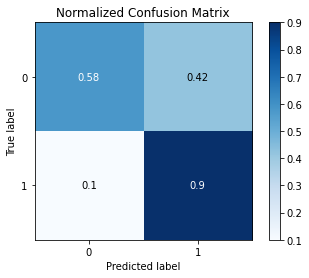

In [53]:
# modelo final
xgb = XGBClassifier(learning_rate=0.001 , n_estimators=50, max_depth=1, min_child_weight=1, gamma=0.0)
xgb.fit(X_train_rus, y_train_rus)

# fazer a previsão
X_test = scaler.transform(X_test)
y_pred = xgb.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

## CONCLUSÕES
<p align=center>
<img src=https://image.freepik.com/vetores-gratis/aperto-de-mao-de-empresarios-e-grande-lampada-com-engrenagens-giratorias-ideia-de-negocio-lancador-de-negocios-e-desenvolvimento-conceito-de-plano-de-negocios-em-fundo-branco_335657-1733.jpg width="60%"></p>

* Os dados de testes não haviam sido passados para o modelo ainda. No entanto, ele manteve um desempenho próximo àquele estimado anteriormente, graças a um bom trabalho de otimização nos parâmetros.

* Escolhemos Recall pela natureza do problema para avaliar a precisão do modelo, e o modelo tem 90% de chances de prever o churn, o que é um resultado satisfatório, dessa maneira a empresa pode atuar para que diminua os churns.

* Ainda há espaço para se tentar outras técnicas de balanceamento de dados e também técnicas de machine learning como feature engineering e feature selection.